In [13]:
#RUN THIS BEFORE USING
%reset
%matplotlib inline
import network_modules as nm
import graph_measures as gm
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import networkx as nx
import collections
import scipy.signal as sig

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [14]:
slider1 = widgets.IntSlider(min=50, max=5000, step=50, value= 50, description = 'n')
slider2 = widgets.IntSlider(min=1, max=10, value=1, description = 'm')
slider3 = widgets.FloatSlider(min=0, max=10, value=1, description = 'a')
slider4 = widgets.FloatSlider(min=0, max=2*np.pi, value=0, description = 'b')
slider5 = widgets.FloatSlider(min=0, max=1, value=0, description = 'c')
slider6 = widgets.FloatSlider(min=0, max=10, value=1, description = 'K')
display(slider1, slider2, slider3, slider4, slider5,slider6)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installe

In [16]:
n = slider1.value
m = slider2.value
print('n = ',n)
print('m = ',m)
G = nm.create_network('BA',n,m)

n =  50
m =  1


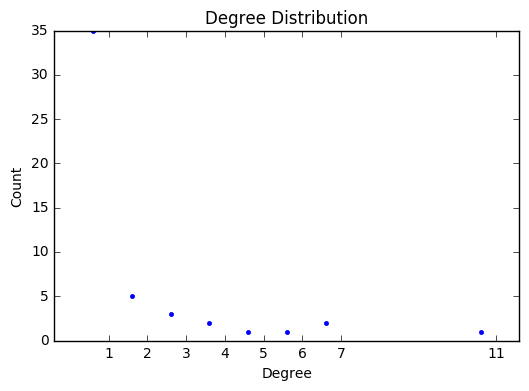

In [17]:
gm.degree_distribution(G)

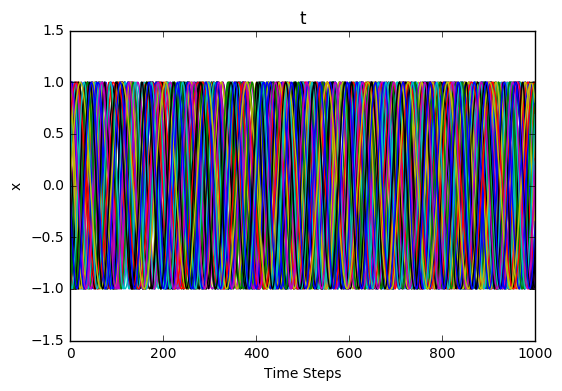

In [18]:
#Parameter Initialization

distributions = [(n,0,2*np.pi,'uniform'),(n,10,2,'normal')]
states = nm.create_vec_states(distributions)
z = np.cos(states[:,0]) + 1j * np.sin(states[:,0])
w = 1j * states[:,1]
x = [[a,b] for a,b in zip(z,w)]

def currynode(w):
    def node(x):   #node function
        return np.array([1j * x[0] * w + x[0]*(1-abs(x[0])),0*1j]) # apply limit cycle term to keep in a circle
    return node

h = [currynode(w) for w in states[:,1]]

def f(x,y): #coupling function
    a = slider3.value
    b = slider4.value
    c = slider5.value
    K = slider6.value
    phi = np.angle(y[0])-np.angle(x[0])
    return np.array([1j * x[0] * complex(K*(np.sin(a*phi+b)+c),0),0*1j])

M = np.identity(n) #Measurement Matrix
N = 0 #Noise Variance

oscillator = nm.nmodel(G,x,h,f,M,N,dt=.01)
oscillator.run(10)
nm.state_course(np.real(nm.reduce_state(0,oscillator.x)))

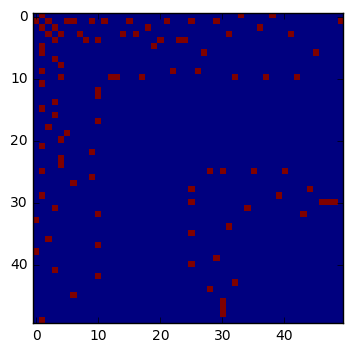

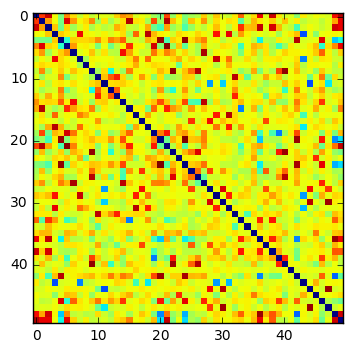

In [19]:
nm.plt_graph(oscillator.G)
plt.figure()
x = gm.cross_func(nm.reduce_state(0,oscillator.x),gm.phase_synchrony)
plt.imshow(x, interpolation= "nearest")


C:\Users\Rohit\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


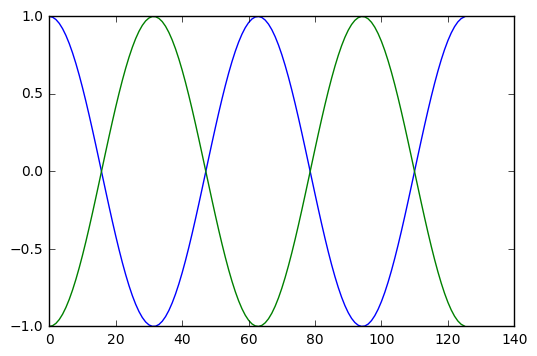

(-1-1.22779872689e-16j)


In [20]:
def frange(start, stop, step):  
    i = start
    while i < stop:
        yield i
        i += step
        
@interact(off = (0.0,2*np.pi))
def f(off):
    x = np.matrix([np.cos(x) + 1j*np.sin(x) for x in frange(0,4*np.pi,.1)])
    y = np.matrix([np.cos(x + off) + 1j*np.sin(x + off) for x in frange(0,4*np.pi,.1)])
    plt.figure()
    plt.plot(np.array(x)[0])
    plt.plot(np.array(y)[0])
    plt.show()
    print(gm.cor(x,y))
    

In [21]:
f, t, s = sig.spectrogram(signal, fs = 1000, window, nperseg, noverlap, nfft)
f, Pxx = sig.welch(signal, fs = 1000, window, nperseg, noverlap, nfft)


SyntaxError: positional argument follows keyword argument (<ipython-input-21-bf0a5f93b85b>, line 1)